In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import seaborn as sns
import re
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [243]:
def over_connected(graph, upper, is_cov) :

    G = graph.flatten()
    cross_thr, full_thr = 50, 70
    # No such over-connected graphs in covariance matrices and not same thresholds with Laplacian (revert==True)
    if is_cov : 
        return False
    # If on full symmetric matrix, the threshold count of pixels has to be doubled
    if not upper :
        cross_thr = 2*cross_thr
        full_thr = 2*full_thr
    if (G > 0.6).sum() >= cross_thr :
        return True
    elif (G > 0.4).sum() >= full_thr : 
        return True
    else : 
        return False

def load_graphs(input_cov, input_lapl, class_dict, upper, revert, over_conn) :

    data_cov, data_lapl, data_labels = [], [], [] # data contains the graphs as tensors and data_labels the associated seizure type labels
    i = 0

    for szr_type in class_dict.keys() :

        szr_label = class_dict[szr_type]

        over_idx = [] # list of index of the files that are kept

        # Retrieve laplacian graphs
        for _, _, lapl_files in os.walk(os.path.join(input_lapl,szr_type)) :
            
            for i, npy_file in enumerate(lapl_files) :
                A = np.load(os.path.join(input_lapl,szr_type,npy_file))
                # Normalise A (already normalised depending on the input)
                A = A/np.amax(A.flatten())

                if revert : L = np.diag(np.sum(A,axis=1)) - A
                else : L = A
                
                # Only keep upper triangle as matrix is symmetric
                if upper : L = np.triu(L, 0)

                if over_conn : is_over_conn = over_connected(A, upper=False, is_cov=False)
                else : is_over_conn = False

                if not is_over_conn :

                    # Change to tensor and reshape for dataloader
                    L = torch.tensor(L).view(1,20,20)
                    
                    data_lapl.append(L)
                    data_labels.append(szr_label)

                    over_idx.append(i)

        # Retrieve covariance graphs
        for _, _, cov_files in os.walk(os.path.join(input_cov,szr_type)) :
            
            for j, npy_file in enumerate(cov_files) :

                # If either over-connectivity is ignored or the corresponding adjacency graph was not deemed over-connected
                if (not over_conn) or (j in over_idx) : 

                    A = np.load(os.path.join(input_cov,szr_type,npy_file))
                    # Normalise A (already normalised depending on the input)
                    L = A/np.amax(A.flatten())
                    
                    # Only keep upper triangle as matrix is symmetric
                    if upper : L = np.triu(L, 0)
                    # Change to tensor and reshape for dataloader
                    L = torch.tensor(L).view(1,20,20)
                    
                    data_cov.append(L)
                
    
    return np.array(data_cov, dtype=object), np.array(data_lapl, dtype=object), np.array(data_labels)

def train_test_data(input_cov, input_lapl, class_dict, upper, revert, over_conn) :

    train_cov, train_lapl, train_labels = load_graphs(os.path.join(input_cov,'train'), os.path.join(input_lapl,'train'), class_dict, upper, revert, over_conn)
    test_cov, test_lapl, test_labels = load_graphs(os.path.join(input_cov,'dev'), os.path.join(input_lapl,'dev'), class_dict, upper, revert, over_conn)

    return train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels

def to_set(train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels) :

    # Oversampling (train set only) to have balanced classification without dropping information
    PD = pd.DataFrame(train_labels, columns=['label'])
    no_0, no_1 = len(PD[PD['label']==0]), len(PD[PD['label']==1])
    R = math.floor(no_0/no_1) # Multiply the dataset by this ratio, then add (no_0 - R*no_1) randomly selected entries from the smallest dataset

    trainset, testset = [], []
    for i in range(len(train_cov)) :
        if train_labels[i] == 1 : # Under-represented class :
            # The dataloader later shuffles the data
            for r in range(R) :
                trainset.append((torch.cat((train_cov[i], train_lapl[i]), 0),train_labels[i]))
        else :
            trainset.append((torch.cat((train_cov[i], train_lapl[i]), 0),train_labels[i]))
    
    # Compensate the remaining imbalance => draw (no_0 - R*no_1) elements from already present elements
    Add = random.sample(PD[PD['label']==1].index.to_list(),no_0 - R*no_1)
    for idx in Add :
        trainset.append((torch.cat((train_cov[idx], train_lapl[idx]), 0),train_labels[idx]))

    # Generate the testset
    for j in range(len(test_cov)) :
        testset.append((torch.cat((test_cov[j], test_lapl[j]), 0),test_labels[j]))

    return trainset, testset

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 2)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout1(self.pool1(self.relu1(self.conv1(x))))
        x = self.dropout2(self.pool2(self.relu2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.dropout4(self.relu4(self.fc2(x)))
        x = self.fc3(x)
        return F.softmax(x,dim=1)

def train_model(CNN, trainloader, batch_size, optimizer, loss_criterion, gamma, nb_epochs, plot) :

    total_L = []
    print('Batch_size : ',batch_size,'\nLearning rate : ',gamma,'\n')
    for epoch in range(nb_epochs): 
        i = 0
        temp_L = []
        for data in trainloader:
            X, y = data
            optimizer.zero_grad()
            X, y = X.float(), y.type(torch.LongTensor)
            output = CNN(X)

            loss = loss_criterion(output, y)
            loss.backward()
            optimizer.step() 
            temp_L.append(loss)

            i += 1
        total_L.append(sum(temp_L)/float(len(temp_L)))
        print(f"Epoch : {epoch}, Loss : {round(total_L[-1].item(),6)}")

    if plot :
        loss_plot = np.array([T.detach().numpy() for T in total_L])
        plt.figure(figsize=(4.3,4))
        sns.set()
        plt.plot(loss_plot)
        plt.title('Evolution of the loss')
        plt.xlabel('Epoch');plt.ylabel('Loss');

    return round(total_L[-1].item(),6)

def compute_accuracy(testloader, CNN, last_loss, classes, plot) :

    correct = 0
    total = 0

    images = []
    y_pred, y_true = [], []

    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            X_test, labels = data
            X_test, labels = X_test.float(), labels.type(torch.LongTensor)
            # Calculate outputs by running images through the network
            outputs = CNN(X_test)

            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            
            images.extend([x.detach().numpy() for x in X_test])
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            _, predictions = torch.max(outputs, 1)
            # Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    TOT_ACC = 100 * correct / total
    F1 = 100 * f1_score(y_true, y_pred, average='weighted')

    print('\nFinal loss : ',last_loss)
    print(f'Unweighted total accuracy on test : {round(TOT_ACC,1)} %')
    print(f'Weighted F1-score on test : {round(F1,1)} %')

    # Print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for {:5s} is: {:.1f} %".format(classname, accuracy))
    
    C = confusion_matrix(y_true, y_pred)
    print(f'\nConfusion matrix :\n{C}\n')

    if plot :
        df_cm = pd.DataFrame(C, index=classes, columns=classes)
        plt.figure(figsize=(4.3,4))
        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', cbar=False) 
        plt.title('Confusion matrix')
        plt.ylabel('True label'); plt.xlabel('Predicted label')
        plt.tight_layout()
    
    return images, y_pred, y_true


In [244]:

def keep_adj(shap_numpy, test_numpy, x) :
    # x = 0 for cov, x = 1 for adjacency matrix as data with two channels, and reshape
    shap_numpy_adj= [shap_numpy[i][:,:,:,x].reshape((shap_numpy[0].shape[0],20,20,1)) for i in range(len(shap_numpy))]
    test_numpy_adj = test_numpy[:,:,:,x].reshape((test_numpy.shape[0],20,20,1))

    return shap_numpy_adj, test_numpy_adj


In [245]:

def class_shap_pixels(class_shaps) :

    shaps = class_shaps
    for i in range(len(class_shaps)) :
        
        # Detect all the pixels that show a positive 
        shaps[i] = np.sign(shaps[i])
        # ReLU the matrix
        shaps[i] = np.maximum(shaps[i], 0)

    # Sum all the shap arrays into one
    graph = np.sum(shaps,axis=0)

    return graph/np.amax(graph.flatten())

def top_channel_pairs(channels, S) :

    P = np.empty((20,20), dtype=object)
    for i in range(P.shape[0]) :
        for j in range(P.shape[1]) :
            P[i,j] = channels[i]+' x '+channels[j]

    top_idx_flat = np.argsort(S.flatten())[::-1] # In descending order, highest-valued pixel first
    return P.flatten()[top_idx_flat]

def dict_count_channels(channels, S) :
    ch_count = {ch: 0 for ch in channels}
    # Increase count of all channels appearing in the S matrix
    for i in range(20) :
        for j in range(20) :
            ch_count[channels[i]] += S[i,j]
            ch_count[channels[j]] += S[i,j]
    # Sort the items, highest count first
    return dict(sorted(ch_count.items(), key=lambda item: item[1], reverse=True))


The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.



Final loss :  0
Unweighted total accuracy on test : 70.5 %
Weighted F1-score on test : 69.8 %
Accuracy for FNSZ  is: 81.7 %
Accuracy for GNSZ  is: 51.1 %

Confusion matrix :
[[245  55]
 [ 85  89]]



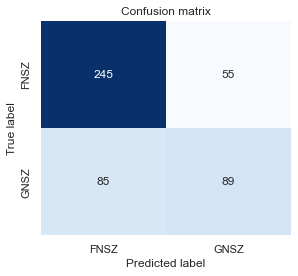

In [246]:
classes = ['FNSZ','GNSZ']

input_cov = '../data/v1.5.2/graph_cov_low_100'
input_lapl = '../data/v1.5.2/graph_lapl_low_50' 
batch_size = 10
upper, revert, over_conn = True, False, True
input_model = 'model_dual_CNN.pt'
plot = True

class_dict = {}
for i, szr_type in enumerate(classes) :
    class_dict[szr_type] = i

train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels = train_test_data(input_cov, input_lapl, class_dict, upper, revert, over_conn)
# Turn into a set with the label to feed the dataloader and oversample the least represented class
trainset, testset = to_set(train_cov, train_lapl, test_cov, test_lapl, train_labels, test_labels)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# Retrieve already trained model
CNN = torch.load(input_model)
CNN.eval()
last_loss = 0

images, y_pred, y_true = compute_accuracy(testloader, CNN, last_loss, classes, plot)


In [247]:
def plot_ex_shap_mask(images, idx, e, y_true, classes) :

    idx_0 = [i for i in idx if y_true[i]==0]
    idx_1 = [i for i in idx if y_true[i]==1]
    tries = [158, 38] #random.sample(idx_1, 2) + random.sample(idx_1, 2)
    print(tries)
    test_images = images[tries]

    shap_values_short = e.shap_values(test_images)

    shap_numpy_short = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_short]
    test_numpy_short = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

    im_names = np.vectorize(lambda x : classes[x])([y_true[j] for j in tries]).tolist()
    # Add im_namees text to the left of the figure
    #
    labels = np.array([classes,['','']])# np.array(len(test_images)*[classes])

    shap_numpy_short_adj, test_numpy_short_adj =keep_adj(shap_numpy_short, test_numpy_short, x=1)

    # plot the feature attributions
    print('\nTrue class of shap examples on the left (top to bottom) :',im_names,'\n')
    shap.image_plot(shap_numpy_short_adj, -test_numpy_short_adj, labels=labels, labelpad=20)

In [248]:
np.array([classes,['','']])

array([['FNSZ', 'GNSZ'],
       ['', '']], dtype='<U4')

[158, 38]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



True class of shap examples on the left (top to bottom) : ['GNSZ', 'FNSZ'] 



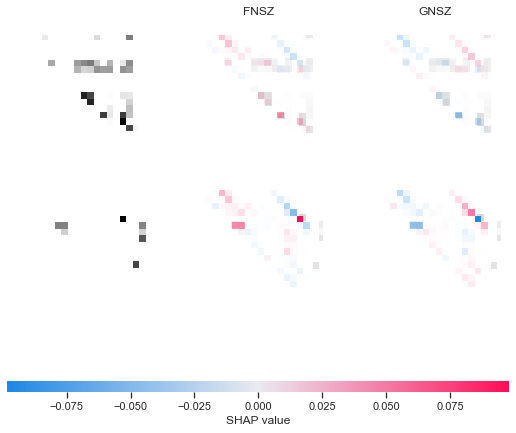

In [249]:
import shap

# Turn the list to a tensor
images = torch.tensor(np.array(images))

# Find matching indices between y_true and y_pred and only pick test images amongst those 
idx = [i for i in range(len(y_true)) if y_true[i]==y_pred[i]]

background = images[idx] # Keep all images correctly classified by the trained model

e = shap.DeepExplainer(CNN, background)

if plot : plot_ex_shap_mask(images, idx, e, y_true, classes)

# FNSZ : 190, 158 (!)
# GNSZ : 38

In [250]:

shap_values = e.shap_values(background) # Computationally heavy on all images


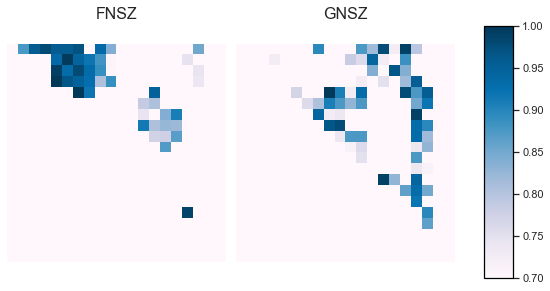

In [251]:
# Only keeping the channel with the adjacency graphs
shap_numpy_adj = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2)[:,:,:,1] for s in shap_values]

# Retrieve the names of the 20 channels and their order to relate our graphs to the brain connectivity
parameters = pd.read_csv('../data_preparation/parameters.csv', index_col=['parameter'])
channels = np.array(re.split(';',str(parameters.loc['montage']['value'])))

S_list = []

for binary_C, C in enumerate(classes) :

    # Indices of elements of idx, which are themselves indices of elements of y_true of class 'C'
    idx_C = [i for i  in range(len(idx)) if y_true[idx[i]]==binary_C]
    # Select the arrays of SHAP values that explain the impact on the classification output 'C', and only for the graphs that were rightly classified as 'C'
    C_shaps = shap_numpy_adj[binary_C][idx_C]
    
    # Compute the summed up SHAP output on all graphs for each class so as to have one graph that sums it all up
    S_C = class_shap_pixels(C_shaps)
    S_list.append(S_C)

    # Sort the channel pairs according to highest pixel value
    #print('For class ',C,':\n\nTop 6 channel pairs that resulted in the highest SHAP pixel value :\n',top_channel_pairs(channels, S_C)[:6],'\n')

    # Sort the channels according to occurence in the S pixels
    ch_count_C = dict_count_channels(channels, S_C)
    #print('For class ',C,':\n\nChannels sorted in function of their contribution to the SHAP summed up graph :\n',list(ch_count_C.keys()),'\n')

# Plot the summed up matrix with the SHAP values for each class
if plot :
    fig, ax = plt.subplots(nrows=1, ncols=len(classes), figsize=(8,5))
    sns.set_theme()
    for i in range(len(classes)) :
        im = ax[i].imshow(S_list[i], vmin=0.7, vmax=1, cmap='PuBu')
        ax[i].set_title(classes[i], pad=25, fontsize=16)
        #ax[i].grid(False)
        ax[i].axis('off')

    #fig.suptitle('Overall thresholded positive contribution to SHAP values by all pixels', y=0.9)
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.outline.set_edgecolor('black')
